# Histopathologic Cancer Detection

## Introduction

Kaggle competition: https://www.kaggle.com/competitions/histopathologic-cancer-detection/

The goal of this competition is to write an algorithm capable of identifying metastatic breast cancer from digital pathology scans. This clearly has strong implications in the medical imaging and diagnosis field. For the purpose of this class, we will be implementing a Convolutional Neural Network (CNN).

## Setup

In [1]:
# import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, MaxPool2D
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
import os

In [2]:
# path to data
path = "/Users/clairerobbins/Documents/MS-DS CU Boulder/Introduction to Deep Learning/Histopathologic Cancer Detection/histopathologic-cancer-detection/" 
train_path = path + 'train/'
test_path = path + 'test/'

## EDA

In [3]:
# define & clean train dataframe
df_train = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})
df_train['id'] = df_train.path.map(lambda x: x.split('/')[9].split(".")[0])
labels = pd.read_csv(train_path+"train_labels.csv")
df_train = df_train.merge(labels, on = "id")
df_train.head(3)

,path,id,label
0,/Users/clairerobbins/Documents/MS-DS CU Boulde...,99ef485f205645918613cd04281098daa7c17819,1
1,/Users/clairerobbins/Documents/MS-DS CU Boulde...,6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0,0
2,/Users/clairerobbins/Documents/MS-DS CU Boulde...,9c043ab2adadfeb758c71d21432fccd3e43565c0,1


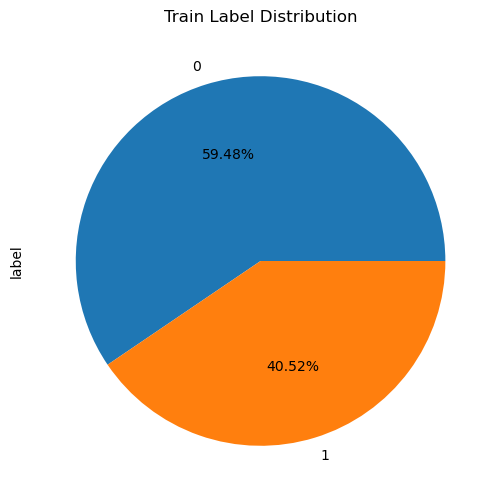

In [4]:
# visualize classification breakdown
df_train['label'].value_counts().plot(figsize=(6,6),kind='pie',autopct='%.2f%%')
plt.title('Train Label Distribution')
plt.show()

In [5]:
# define & clean test dataframe
df_test = pd.DataFrame({'path': glob(os.path.join(test_path,'*.tif'))})
df_test['id'] = df_test.path.map(lambda x: x.split('/')[9].split(".")[0])
df_test['label'] = [None for i in range(len(df_test))]
df_test.head(3)

,path,id,label
0,/Users/clairerobbins/Documents/MS-DS CU Boulde...,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,None
1,/Users/clairerobbins/Documents/MS-DS CU Boulde...,1f9ee06f06d329eb7902a2e03ab3835dd0484581,None
2,/Users/clairerobbins/Documents/MS-DS CU Boulde...,19709bec800f372d0b1d085da6933dd3ef108846,None


## Model Development & Architecture

In my initial set up, I chose to split my train data into train & validation data, to get a sense of how the model is performing in real time. Given the smaller image size, I started off with a simple model to minimize overfitting, and tuned my hyperparameters from that point. Additionally, I found I had to clean the data because some of the files downloaded from the were erroneous.

In [6]:
# split into train & validate datasets
train, validate = train_test_split(df_train, test_size=0.2)

In [7]:
# extract image metadata from each train image & drop invalid files
def clean_files(df):
    raw_data = []
    labels = []
    for index,row in df.iterrows():
        try:
            raw_data.append(np.array(Image.open(row['path'])))
            labels.append(row['label'])
        except:
            pass
    return np.array(raw_data), np.array(labels)

In [8]:
# run clean function on data
train_raw, train_labels = clean_files(train)
validate_raw, validate_labels = clean_files(validate)

In [9]:
kernel_size = (3, 3)
pool_size = (2, 2)
first_filters = 16
second_filters = 32
third_filters = 64

dropout_conv = 0.2
dropout_dense = 0.4

model = Sequential()

# Conv layer 1
model.add(Conv2D(first_filters, kernel_size, input_shape=(96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# Conv layer 2
model.add(Conv2D(second_filters, kernel_size))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# Conv layer 3
model.add(Conv2D(third_filters, kernel_size))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# Fully connected (dense) layer
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

# Activation function
model.add(Dense(1, activation="sigmoid"))

batch_size = 64
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 batch_normalization (Batch  (None, 94, 94, 16)        64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 94, 94, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 47, 47, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4

In [10]:
# model fit
model.fit(train_raw, train_labels, epochs=10, validation_data=(validate_raw, validate_labels))

Epoch 1/10
3530/3530 [==============================] - 162s 46ms/step - loss: 0.3989 - accuracy: 0.8264 - val_loss: 0.7339 - val_accuracy: 0.6742
Epoch 2/10
3530/3530 [==============================] - 155s 44ms/step - loss: 0.3429 - accuracy: 0.8545 - val_loss: 0.4416 - val_accuracy: 0.7947
Epoch 3/10
3530/3530 [==============================] - 159s 45ms/step - loss: 0.2981 - accuracy: 0.8771 - val_loss: 0.3924 - val_accuracy: 0.8252
Epoch 5/10
3530/3530 [==============================] - 159s 45ms/step - loss: 0.2635 - accuracy: 0.8931 - val_loss: 0.5034 - val_accuracy: 0.7757
Epoch 7/10
3530/3530 [==============================] - 159s 45ms/step - loss: 0.2502 - accuracy: 0.9009 - val_loss: 0.6774 - val_accuracy: 0.8097
Epoch 8/10
3530/3530 [==============================] - 158s 45ms/step - loss: 0.2401 - accuracy: 0.9056 - val_loss: 0.6318 - val_accuracy: 0.7655
Epoch 9/10
3530/3530 [==============================] - 158s 45ms/step - loss: 0.2308 - accuracy: 0.9092 - val_loss: 0

## Hyperparameter Tuning & Analysis

Here is my rationale for the chosen hyperparameters:

1. **Reduced Number of Filters**:
   - Improve training times while still capturing relevant features in your images and prevent overfitting

2. **Adjusted Dropout Rates**:
   - Retaining more information from the network's activations

3. **Smaller Dense Layer (128 neurons)**:
   - Reduced dense layer from 256 neurons to 128 neurons, to execute faster training and less risk of overfitting

4. **Batch Normalization**:
   - Faster convergence and better generalization

5. **Activation Functions**:
   - ReLU (Rectified Linear Activation) is used as the activation function after each convolutional and dense layer.
   - Computationally efficient and helps mitigate the vanishing gradient problem

6. **Loss Function and Optimizer**:
   - Binary cross-entropy loss is a natural choice for binary classification
   - The Adam optimizer is chosen for its adaptive learning rate and efficient convergence

## Predictions

In [11]:
# extract image metadata from each test image
def clean_files_test(df):
    ids = []
    raw_data = []
    for index,row in df.iterrows():
        raw_data.append(np.array(Image.open(row['path'])))
    return np.array(raw_data)

In [12]:
# run clean function on test data
test_raw = clean_files_test(df_test)

In [13]:
# predict using trained model
predictions = model.predict(test_raw)

1796/1796 [==============================] - 18s 10ms/step


In [14]:
# convert prediction percentages to binary classification
final_predictions = []
for i in predictions:
    if i > 0.5:
        final_predictions.append(1)
    else:
        final_predictions.append(0)

In [15]:
# generate submission file
submission = pd.DataFrame({'id': df_test['id'], 'label': final_predictions})
submission.to_csv('submission.csv')

## Conclusion

My model achieved a 91% accuracy on the training data, 90% on the validation data, and 85% on my kaggle submission. This indicates there was some aspect of overfitting, although not an agregious amount.

In an effort to prevent overfitting, I implemented concepts such as fewer filters per convolutional layer and coupled with calibrated dropout rates. This project aimed to excel in pinpointing cancerous patterns within small digital pathology images. Progress in this space fuels the ongoing quest for sharper, swifter cancer diagnoses, propelling CNNs' potential in medical diagnostics.